# <img style="float: left; padding-right: 10px; width: 45px" src="fig/iacs.png"> S-109A Introduction to Data Science 
## Homework 4 - Regularization 



**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Nathan Goldberg, Erik Johnsson
<hr style="height:2pt">

In [594]:
from IPython.core.display import HTML
def css_styling(): styles = open("cs109.css", "r").read(); return HTML(styles)
css_styling()

import these libraries

In [635]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

#import statsmodels.api as sm

np.random.seed(42)

from pandas.core import datetools
%matplotlib inline

# Continuing Bike Sharing Usage Data

In this homework, we will focus on regularization and cross validation. We will continue to build regression models for the Capital Bikeshare program in Washington D.C.  See homework 3 for more information about the Capital Bikeshare data that we'll be using extensively. 



## Data Preparation



<div class='exercise'> <b> Question 1 </b> </div> 
  In HW3 Questions 1-3, you preprocessed the data in preparation for your regression analysis. We ask you to repeat those steps (particularly those in Question 3) so that we can compare the analysis models in this HW with those you developed in HW3.  In this HW we'll be using models from sklearn exclusively (as opposed to statsmodels)
  
**1.1** [From HW3] Read `data/BSS_train.csv` and `data/BSS_test.csv` into dataframes `BSS_train` and `BSS_test`, respectively.  Remove the `dteday` column from both train and test dataset. We do not need it, and its format cannot be used for analysis.  Also remove the `casual` and `registered` columns for both training and test datasets as they make  `count` trivial.   

**1.2** Since we'll be exploring Regularization and Polynomial Features, it will make sense to standardize our data.  Standardize the numerical features. Store the dataframes for the processed training and test predictors into the variables `X_train` and `X_test`.  Store the appropriately shaped numpy arrays for the corresponding train and test `count` columns into `y_train` and `y_test`.

**1.3** Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model to the training set data in `X_train`.  Store the fitted model in the variable `BikeOLSModel`.

**1.4** What are the training and test set $R^2$ scores?  Store the training and test $R^2$ scores of the `BikeOLSModel` in a dictionary `BikeOLS_r2scores` using the string 'training' and 'test' as keys.  

**1.5**   We're going to use bootstrapped confidence intervals (use 500 bootstrap iterations) to determine which of the estimated coefficients for the `BikeOLSModel` are statistically significant at a significance level of 5% .  We'll do so by creating 3 different functions:

1. `make_bootstrap_sample(dataset_X, dataset_y)` returns a bootstrap sample of `dataset_X` and `dataset_y`
2. `calculate_coefficients(dataset_X, dataset_y, model)` returns in the form of a dictionary regression coefficients calculated by your model on `dataset_X` and `dataset_y`.  The keys for regression coefficients dictionary should be the names of the features.  The values should be the coefficient values of that feature calculated on your model.  An example would be {'hum': 12.3, 'windspeed': -1.2, 'Sunday': 0.6 ... }
3. `get_significant_predictors(regression_coefficients, significance_level)` takes as input a list of regression coefficient dictionaries (each one the output of `calculate_coefficients` and  returns a python list of the feature names of the significant predictors e.g. ['Monday', 'hum', 'holiday', ... ]

In the above functions `dataset_X` should always be a pandas dataframe with your features, `dataset_y` a numpy column vector with the values of the response variable and collectively they form the dataset upon which the operations take place. `model` is the `sklearn` regression model that will be used to generate the regression coefficients. `regression_coefficients` is a list of dictionaries of numpy arrays with each numpy array containing the regression coefficients (not including the intercept) calculated from one bootstrap sample.  `significance_level` represents the significance level as a floating point number.  So a 5% significance level should be represented as 0.05.  


Store the feature names as a list of strings in the variable `BikeOLS_significant_bootstrap` and print them for your answer.


### Answers

#### 1.1 Read `data/BSS_train.csv` and `data/BSS_test.csv` into Pandas DataFrames

In [657]:
# Read Data
BSS_train = pd.read_csv("data/BSS_train.csv")
BSS_test = pd.read_csv("data/BSS_test.csv")

In [658]:
# Remove columns
BSS_train = BSS_train.drop(columns=['Unnamed: 0', 'dteday', 'casual', 'registered'])
BSS_test = BSS_test.drop(columns=['Unnamed: 0', 'dteday', 'casual', 'registered'])

In [659]:
# View
BSS_train.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,0,0,0,0,0.24,0.2879,0.81,0.0,16,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0.22,0.2727,0.80,0.0,40,0,...,0,0,0,0,0,0,1,0,0,0
2,2,0,0,0,0.22,0.2727,0.80,0.0,32,0,...,0,0,0,0,0,0,1,0,0,0
3,3,0,0,0,0.24,0.2879,0.75,0.0,13,0,...,0,0,0,0,0,0,1,0,0,0
4,4,0,0,0,0.24,0.2879,0.75,0.0,1,0,...,0,0,0,0,0,0,1,0,0,0


#### 1.2 Standardizing our data

In [660]:
# Identify numerical predictors
numeric_preds = ['hour']
# specified in Piazza

for predictor in BSS_train.dtypes.index:
    if BSS_train.dtypes[predictor] == float:
        numeric_preds.append(predictor)
        
print("Numeric Preds:", numeric_preds)

Numeric Preds: ['hour', 'temp', 'atemp', 'hum', 'windspeed']


In [661]:
# Standardize numeric columns
for pred in numeric_preds:
    BSS_test[pred] = (BSS_test[pred] - np.mean(BSS_train[pred])) / np.std(BSS_train[pred])
    BSS_train[pred] = (BSS_train[pred] - np.mean(BSS_train[pred])) / np.std(BSS_train[pred])

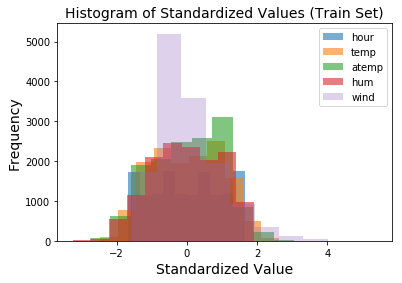

In [662]:
# Check that Standardization Worked

# Plot Histograms
plt.hist(BSS_train['hour'], alpha=.6, label='hour')
plt.hist(BSS_train['temp'], alpha=.6, label='temp')
plt.hist(BSS_train['atemp'], alpha=.6, label='atemp')
plt.hist(BSS_train['hum'], alpha=.6, label='hum')
plt.hist(BSS_train['windspeed'], alpha=.3, label='wind')

# Label
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Standardized Value', fontsize=14)
plt.title('Histogram of Standardized Values (Train Set)', fontsize=14)
plt.legend();

It looks like the standardization worked perfectly for `temp`, `atemp`, and `hum`, but `windspeed` is not exactly distributed normally; instead it has a right skew, probably because of some extreme values.

In [663]:
# Store response and predictor arrays
y_train = BSS_train['counts']
y_test = BSS_test['counts']

x_train = BSS_train.drop(columns=['counts'])
x_test = BSS_test.drop(columns=['counts'])

#### 1.3 Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression.

In [664]:
# Fit Model
BikeOLSModel = LinearRegression()
BikeOLSModel.fit(x_train, y_train)

# Print Coefficients
print("Intercept:", BikeOLSModel.intercept_)
print("\nCoefficients ({}):\n"
      .format(len(BikeOLSModel.coef_)), BikeOLSModel.coef_)

Intercept: 138.2034395688072

Coefficients (31):
 [ 49.95488668 -18.09579787  76.35190255  11.31776458  64.2144082
  12.83245817 -39.67974129   2.74716748  43.1540641   29.54255101
  68.5953343   -7.64302775 -11.67368714 -41.52438417 -33.2927062
 -65.80393392 -93.48048248 -59.2081129  -16.05174746 -16.16015032
 -25.87318084 -10.20425082  -2.66009872  -6.14245821   2.29643998
  -3.16107607   2.88915973  14.94592932   6.78680552 -28.28589048
  42.35693906]


#### 1.4 What are the training and test set $R^2$ scores? Store the $R^2$ scores of the `BikeOLSModel` on the training and test sets in a dictionary `BikeOLS_r2scores`. 

In [665]:
## Report R^2

# Make Predictions
pred_train = BikeOLSModel.predict(x_train)
pred_test = BikeOLSModel.predict(x_test)

# Calculate R^2
r2_ols_train = r2_score(y_train, pred_train)
r2_ols_test = r2_score(y_test, pred_test)

# Print
print("R Squared (OLS Train): {}"
      .format(round(r2_ols_train, 4)))
print("R Squared (OLS Test) : {}"
      .format(round(r2_ols_test, 4)))

R Squared (OLS Train): 0.4065
R Squared (OLS Test) : 0.4064


In [666]:
# Store in Dictionary
BikeOLS_r2scores = {'training':r2_ols_train, 'test':r2_ols_test}
BikeOLS_r2scores

{'training': 0.4065387827969087, 'test': 0.40638554757102285}

#### 1.5 We're going to use bootstrapped confidence intervals to determine which of the estimated coefficients ...

In [667]:
# dataset_x should be a pandas dataframe

## accepts dataset inputs as numpy arrays
def make_bootstrap_sample(dataset_X, dataset_y, size = None):
    
    # by default return a bootstrap sample of the same size as the original dataset
    if not size: size = len(dataset_X)
    
    # Make sure indexes are standard
    dataset_X = dataset_X.reset_index()
    dataset_y = dataset_y.reset_index()
    del dataset_X['index']
    del dataset_y['index']
    
    # Start datasets
    bootstrap_dataset_X = dataset_X[0:0]
    bootstrap_dataset_y = dataset_y[0:0]
    
    # Generate Random Numbers
    random_indices = np.random.choice(size, size)
    
    # Add Rows to Bootstrap Sample
    bootstrap_dataset_X = dataset_X.loc[random_indices]
    bootstrap_dataset_y = dataset_y.loc[random_indices]
    
    # if the X and y datasets aren't the same size, raise an exception
    if len(dataset_X) != len(dataset_y):
        raise Exception("Data size must match between dataset_X and dataset_y")
    
    return (bootstrap_dataset_X, bootstrap_dataset_y)
    

def calculate_coefficients(dataset_X, dataset_y, model):
    
    model = model.fit(dataset_X, dataset_y)
    
    coefficients_dictionary = dict()
    
    for i, col in enumerate(dataset_X.columns):
        coefficients_dictionary[col] = model.coef_.ravel()[i]

    return coefficients_dictionary


def get_significant_predictors(regression_coefficients, p = 0.05):
    
    significant_coefficients = []
    
    # make dataframe of coefficients
    coeffs_df = pd.DataFrame(regression_coefficients)
    
    # for every feature in the dataframe
    for col in coeffs_df.columns:
        
        if (coeffs_df[col].quantile(p/2) > 0 or 
            coeffs_df[col].quantile(1-(p/2)) < 0):
            
            significant_coefficients.append(col)
            
    # return the significant coefficients as a list of strings
    return significant_coefficients

In [668]:
## Find Significant Coefficients
c_dict = []

# For 500 iterations
for n in range(500):
    
    # Make Samples
    x, y = make_bootstrap_sample(x_train, y_train)
    
    # Calculate Coefficients
    c_dict.append(calculate_coefficients(x, y, BikeOLSModel))

In [669]:
# Find Significant Predictors
BikeOLS_significant_bootstrap = get_significant_predictors(c_dict, p = 0.05)
print('Significant Predictors: ', BikeOLS_significant_bootstrap)

Significant Predictors:  ['Apr', 'Aug', 'Cloudy', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Sat', 'Snow', 'Tue', 'fall', 'holiday', 'hour', 'hum', 'spring', 'summer', 'temp', 'windspeed', 'workingday', 'year']


These are very similar to the ones we got in HW3:

[hour
holiday
year
workingday
temp
hum
windspeed
spring
summer
fall
Apr
May
Jun
Jul
Aug
Nov
Sat
Cloudy
Snow]

## Penalization Methods

In HW 3 Question 5 we explored using subset selection to find a significant subset of features.  We then fit a regression model just on that subset of features instead of on the full dataset (including all features).   As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

<div class='exercise'> <b> Question 2 </b> </div> 
  We're going to use Ridge and Lasso regression regularization techniques to fit linear models to the training set.  We'll use cross-validation and shrinkage parameters $\lambda$ from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ to pick the best model for each regularization technique.

**2.1** Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Ridge Regression model on the training data.  Fit a Ridge Regression model on the training set with the selected shrinkage parameter and store your fitted model in the variable `BikeRRModel`.  Store the selected shrinkage parameter in the variable `BikeRR_shrinkage_parameter`.

**2.2** Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Lasso Regression model on the training data.  Fit a Lasso Regression model on the training set with the selected shrinkage parameter and store your fitted model in the variable `BikeLRModel`.  Store the selected shrinkage parameter in the variable `BikeLR_shrinkage_parameter`.

**2.3** Create three dictionaries `BikeOLSparams`, `BikeLRparams`, and `BikeRRparams`.  Store in each the corresponding regression coefficients for each of the regression models indexed by the string feature name.

**2.4** For the Lasso and Ridge Regression models list the features that are assigned a coefficient value close to 0 (i.e. the absolute value of the coefficient is less than 0.1).  How closely do they match the redundant predictors found (if any) in HW 3, Question 5?

**2.5** To get a visual sense of how the features different regression models (Multiple Linear Regression, Ridge Regression, Lasso Regression) estimate coefficients, order the features by magnitude of the estimated coefficients in the Multiple Linear Regression Model (no shrinkage).  Plot a bar graph of the magnitude (absolute value) of the estimated coefficients from Multiple Linear Regression in order from greatest to least.  Using a different color (and alpha values) overlay bar graphs of the magnitude of the estimated coefficients (in the same order as the Multiple Linear Regression coefficients) from Ridge and Lasso Regression.

**2.6** Let's examine a pair of features we believe to be related.  Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

**2.7** Discuss the Results:

1. How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrinkage penalty) in Question 1? 
2. Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
3. Is the significance related to the shrinkage in some way?

*Hint:* You may use `sklearn`'s `RidgeCV` and `LassoCV` classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values.

### Answers

In [670]:
lambdas = [.001, .005, .1, .5, 1, 5, 10, 50, 100, 500, 1000]

#### 2.1 Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Ridge Regression model.

In [671]:
# declare and pass a KFold object to properly shuffle the training data, and/or set the random state
splitter = KFold(5, random_state=42, shuffle=True)

# find the best shrinkage parameter
ridgeCV_object = RidgeCV(alphas=lambdas, cv=splitter)
ridgeCV_object.fit(x_train, y_train)

BikeRR_shrinkage_parameter = ridgeCV_object.alpha_

print('The shrinkage parameter {} best fits our Ridge Regression model.'.format(BikeRR_shrinkage_parameter))

# fit the model with the selected shrinkage paramter on the whole training set
BikeRRModel = Ridge(alpha = BikeRR_shrinkage_parameter).fit(x_train, y_train)

The shrinkage parameter 1 best fits our Ridge Regression model.


In [672]:
# declare and pass a KFold object to properly shuffle the training data, and/or set the random state
splitter = KFold(5, random_state=42, shuffle=True)

ridgeCV_object = RidgeCV(alphas=lambdas, cv=splitter)
ridgeCV_object.fit(x_train, y_train)
print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, "
      .format(ridgeCV_object.alpha_,
              ridgeCV_object.intercept_,
              ridgeCV_object.coef_)
     )

Best model searched:
alpha = 1
intercept = 137.56403988608218
betas = [ 49.97857786 -18.02080272  76.35453127  11.32189537  63.7531548
  13.06082357 -39.69821788   2.76454647  42.19927097  28.28656293
  67.80001081  -7.27735399 -10.85298608 -39.97524629 -31.58056867
 -63.84885363 -91.21513834 -57.01250106 -14.13859288 -14.75552536
 -24.61173966  -9.2763835   -2.65691395  -6.11891389   2.3283544
  -3.13422051   2.88278659  14.94299914   6.82055235 -28.24809088
  28.43733998], 


#### 2.2 Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Lasso Regression model.

In [673]:
# declare and pass a KFold object to properly shuffle the training data, and/or set the random state
splitter = KFold(5, random_state=42, shuffle=True)

# find the best shrinkage parameter
lassoCV_object = LassoCV(alphas=lambdas, cv=splitter)
lassoCV_object.fit(x_train, y_train)

BikeLR_shrinkage_parameter = lassoCV_object.alpha_

print('The shrinkage parameter {} best fits our Lasso Regression model.'.format(BikeLR_shrinkage_parameter))

# fit the model with the selected shrinkage paramter on the whole training set
BikeLRModel = Lasso(alpha = BikeLR_shrinkage_parameter).fit(x_train, y_train)

The shrinkage parameter 0.001 best fits our Lasso Regression model.


In [674]:
print("Mean MSE per lambda:\n")
for i in range(len(lassoCV_object.mse_path_)):
    print(lassoCV_object.alphas_[i], ": ", np.mean(lassoCV_object.mse_path_[i]))

Mean MSE per lambda:

1000.0 :  32441.04807735245
500.0 :  32441.04807735245
100.0 :  32441.04807735245
50.0 :  27514.218913173176
10.0 :  20895.000609607785
5.0 :  20085.076832450453
1.0 :  19479.397233194693
0.5 :  19402.973668675695
0.1 :  19355.478932108126
0.005 :  19342.370515207298
0.001 :  19342.263620634785


Quick sanity test shows that lambda = 0.001 does indeed minimize MSE, although 0.005 is basically the same.

#### 2.3 Create three dictionaries `BikeOLSparams`, `BikeLRparams`, and `BikeRRparams`.  Store in each the corresponding regression coefficients.

In [675]:
# create dictionary for each model
BikeOLSparams = dict()
BikeRRparams = dict()
BikeLRparams = dict()

# store regression coefficients
for i, col in enumerate(x_train.columns):
    BikeLRparams[col] = BikeLRModel.coef_.ravel()[i]
    BikeRRparams[col] = BikeRRModel.coef_.ravel()[i]
    BikeOLSparams[col] = BikeOLSModel.coef_.ravel()[i]
    
BikeOLSparams

{'hour': 49.68489366758672,
 'holiday': -17.345879425180065,
 'year': 78.1197235088173,
 'workingday': 8.392841644403624,
 'temp': 80.65724867825335,
 'atemp': -0.6824513466573559,
 'hum': -40.61363928327511,
 'windspeed': 2.4384838586816064,
 'spring': 40.33724621102253,
 'summer': 21.80013474322075,
 'fall': 64.5356250049359,
 'Feb': -15.653791730469381,
 'Mar': -6.404122973882548,
 'Apr': -37.78591159556143,
 'May': -35.05145042357555,
 'Jun': -69.02765095414331,
 'Jul': -93.6348705386239,
 'Aug': -61.92602348676226,
 'Sept': -15.996748508752441,
 'Oct': -12.40552146112708,
 'Nov': -25.510427507625767,
 'Dec': -10.437500572153732,
 'Mon': -1.0581303420769477,
 'Tue': -7.348243746849885,
 'Wed': 1.5287828271774004,
 'Thu': -0.11500925673797954,
 'Fri': -1.9604372622845259,
 'Sat': 13.34862823320835,
 'Cloudy': 7.300829229727744,
 'Snow': -30.80704507009287,
 'Storm': 50.70144672425164}

#### 2.4 For the Lasso and Ridge Regression models list the features that are assigned a coefficient value close to 0 ...

In [677]:
# get features with coefficients < 0.1
redundantLRfeatures = [k for k, v in BikeLRparams.items() if abs(v) < .1]
redundantRRfeatures = [k for k, v in BikeRRparams.items() if abs(v) < .1]
redundantHW3features = ['workingday', 'windspeed', 'summer', 'Feb',
                        'Mar', 'Apr', 'May', 'Jun', 'Sept', 'Oct', 'Nov', 'Dec',
                        'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Storm']

not_in_HW3 = [feat for feat in redundantLRfeatures if feat not in redundantHW3features]

print('The redundant features found in the Ridge model are:\n', redundantRRfeatures, '\n')
print('The redundant features found in the Lasso model are:\n', redundantLRfeatures, '\n')
print('The redundant features found in HW3, Question 5, are:\n', redundantHW3features, '\n')

The redundant features found in the Ridge model are:
 [] 

The redundant features found in the Lasso model are:
 [] 

The redundant features found in HW3, Question 5, are:
 ['workingday', 'windspeed', 'summer', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Storm'] 



# Redundant according to BIC selection; by < .1 criterion there are no redundant features either. 0.1 is silly anyway (0.1 bike rides means nothing).

lasso-different rates; ridge-??

<HR>
Our Ridge and Lasso models found that no features were redundant. Oppositely, our implementation of forward step-wise selection in HW3 found that 20 features were redundant.
<HR>

#### 2.5 To get a visual sense of how the features different regression models (Multiple Linear Regression, Ridge Regression, Lasso Regression) estimate coefficients, order the features by magnitude of the estimated coefficients in the Multiple Linear Regression Model (no shrinkage).

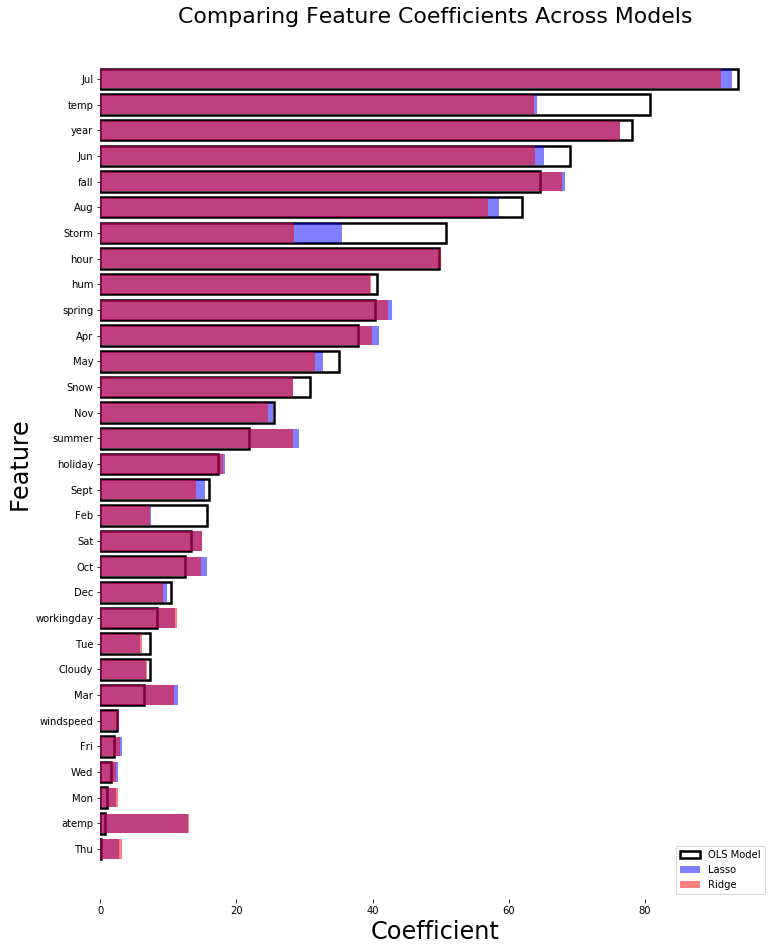

In [678]:
# Make Dictionaries out of Absolute Values of Coefficients
BikeRRparams_abs = {k: abs(v) for k, v in BikeRRparams.items()}
BikeLRparams_abs = {k: abs(v) for k, v in BikeLRparams.items()}
BikeOLSparams_abs = {k: abs(v) for k, v in BikeOLSparams.items()}

# Make DataFrame out of Dictionaries
params_df = pd.DataFrame([BikeOLSparams_abs, BikeLRparams_abs, BikeRRparams_abs])

# Reorder Columns
ordered_cols = [col for _, col in sorted(zip(params_df.loc[0], params_df.columns))]
params_df = params_df[ordered_cols]

fig, ax = plt.subplots(1,1, figsize=(12,16))

ax.barh(params_df.columns, params_df.loc[0], color='w', edgecolor='black', linewidth=2.5, label='OLS Model')
ax.barh(params_df.columns, params_df.loc[1], .75, color='b', alpha=0.5, label='Lasso')
ax.barh(params_df.columns, params_df.loc[2], .75, color='r', alpha=0.5, label='Ridge')

ax.set_ylabel('Feature', fontsize=24)
ax.set_xlabel('Coefficient', fontsize=24)
ax.set_title('Comparing Feature Coefficients Across Models', fontsize=22)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


ax.legend();



#### 2.6 Let's examine a pair of features we believe to be related.  Is there a difference in the way Ridge and Lasso regression assign coefficients ...v

<HR>
Ridge goes smoothly to zero (triangle shape); Lasso goes to zero and stays there (branch shape)>
<HR>

#### 2.7.1 How do the estimated coefficients compare to or differ from ...

<HR>
The coefficients estimated with Ridge and Lasso Regression are generally lower than the ones found with simple linear regression. None of the coefficients found with Ridge and Lasso Regression are significantly larger than the ones found with OLS.
<HR>

#### 2.7.2 Is there a difference between coefficients estimated by the two shrinkage methods ...

<HR>
In general, the coefficients estimated with Lasso are slightly larger than the ones found with Ridge. This might be because the shrinkage parameter used in our Lasso model was much smaller than the parameter we used in our Ridge model.
<HR>

#### 2.7.3 Is the significance related to the shrinkage in some way?

<HR>
Your answer here
<HR>

<div class='exercise'> <b> Question 3: Polynomial Features, Interaction Terms, and Cross Validation </b> </div>


We would like to fit a model to include all main effects and polynomial terms for numerical predictors up to the $4^{th}$ order. More precisely use the following terms: 
 - predictors in `X_train` and `X_test`
 - $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ for each numerical predictor $X_j$

**3.1** Create an expanded training set including all the desired terms mentioned above. Store that training set (as a pandas dataframe) in the variable `X_train_poly`.  Create the corresponding test set and store it as a pandas dataframe in `X_test_poly`.

**3.2** Discuss the following:

1. What are the dimensions of this 'design matrix' of all the predictor variables in 3.1?  
2. What issues may we run into attempting to fit a regression model using all of these predictors?

**3.3** Let's try fitting a regression model on all the predictors anyway.  Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model to the training set data in `X_train_poly`.  Store the fitted model in the variable `BikeOLSPolyModel`.

**3.4** Discuss the following:
1. What are the training and test $R^2$ scores? 
2. How does the model performance compare with the OLS model on the original set of features in Question 1?

**3.5** The training set $R^2$ score we generated for our model with polynomial and interaction terms doesn't have any error bars.  Let's use cross-validation to generate sample sets of $R^2$ for our model. Use 5-fold cross-validation to generate $R^2$ scores for the multiple linear regression model with polynomial terms.  What are the mean and standard deviation of the $R^2$ scores for your model.

**3.6** Visualize the $R^2$ scores generated from the 5-fold cross validation as a box and whisker plot.

**3.7** We've used cross-validation to generate error bars around our $R^2$ scores, but another use of cross-validation is as a way of model selection.  Let's construct the following model alternatives:

1. Multiple linear regression model generated based upon the feature set in Question 1 (let's call these the base features.
2. base features plus polynomial features to order 2
3. base features plus polynomial features to order 4

Use 5-fold cross validation on the training set to select the best model.  Make sure to evaluate all the models as much as possible on the same folds.  For each model generate a mean and standard deviation for the $R^2$ score.

**3.8** Visualize the $R^2$ scores generated for each model from 5-fold cross validation in box and whiskers plots.  Do the box and whisker plots influence your view of which model was best?

**3.9** Evaluate each of the model alternatives on the test set.  How do the results compare with the results from cross-validation?

### Answers

#### 3.1 Create an expanded training set including all the desired terms mentioned above. Store that training set (as a numpy array) in the variable `X_train_poly`....

In [554]:
# build design matrix for degree 4 polynomial regression
# Not a generalizable function...

def get_poly_dataset(df):
    
    # get continuous variables
    cont_predictors = df[['hour', 'temp', 'atemp', 'hum', 'windspeed']].copy()

    # convert to numpy array
    design_mat = df.as_matrix()
    
    # degree 4 polynomials
    transformer_4 = PolynomialFeatures(4, include_bias=False)

    # for each continuous predictor
    for predictor in cont_predictors:   
        
        # append new polynomial predictors to the design matrix
        new_predictors = transformer_4.fit_transform(
            cont_predictors[predictor].values.reshape(-1, 1))[:,1:]
        design_mat = np.concatenate([design_mat, new_predictors], axis=1)

    # add the names of new predictors to list of columns   
    new_cols = []
    for i in range(len(cont_predictors.columns)):
        new_cols = new_cols + [cont_predictors.columns[i] + '2',
                               cont_predictors.columns[i] + '3',
                               cont_predictors.columns[i] + '4']
    cols = list(x_train.columns) + new_cols
    
    # recreate DataFrame with new predictors
    design_df = pd.DataFrame(data=design_mat,
                             index=range(len(design_mat)),columns=cols)    
        
    return design_df

In [555]:
# Create Poly Sets
X_poly_train = get_poly_dataset(x_train)
X_poly_test = get_poly_dataset(x_test)

#### 3.2.1 What are the dimensions of this 'design matrix'...**

In [556]:
print("The design matrix has {} rows with {} predictors."
     .format(X_poly_train.shape[0], X_poly_train.shape[1]))

The design matrix has 13903 rows with 46 predictors.


#### 3.2.2 What issues may we run into attempting to fit a regression model using all of these predictors? ...**

# Answer

#### 3.3 Let's try fitting a regression model on all the predictors anyway.  Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model ....

In [557]:
# Fit Model
BikeOLSPolyModel = LinearRegression()
BikeOLSPolyModel = BikeOLSPolyModel.fit(X_poly_train, y_train)

# Print Coefficients
print("Intercept:", BikeOLSPolyModel.intercept_)
print("\nCoefficients ({}):\n"
      .format(len(BikeOLSPolyModel.coef_)), BikeOLSPolyModel.coef_)

Intercept: 145.66440073732647

Coefficients (46):
 [158.38788417  -7.57383006  87.57075962  13.0843503   36.04548208
  33.51458496 -15.8493479    7.38885009  39.96180737  39.2945889
  73.73798121  21.16111567  39.56452529  28.54014135  31.39796931
  20.42467993   0.65103368   8.82763817  32.96511291  32.23745645
   8.44803426  10.57576566  -5.21951605  -3.12466636   2.72802254
   2.91848376   8.20819635  17.42966489 -13.73944289 -68.35024426
 -36.61114824 -50.30757299 -52.28531679  -8.44441772  49.59141077
 -11.41118495  -4.78454482 -28.21930268  -2.89818308   0.34493748
  -8.39825097   2.73814012   1.47090082  -4.44254811  -1.93189516
   0.41989552]


#### 3.4.1 What are the training and test $R^2$ scores?

In [558]:
## Report R^2

# Make Predictions
pred_train = BikeOLSPolyModel.predict(X_poly_train)
pred_test = BikeOLSPolyModel.predict(X_poly_test)

# Calculate R^2
r2_poly_train = r2_score(y_train, pred_train)
r2_poly_test = r2_score(y_test, pred_test)

# Print
print("R Squared (Poly Train): {}"
      .format(round(r2_poly_train, 4)))
print("R Squared (Poly Test) : {}"
      .format(round(r2_poly_test, 4)))

R Squared (Poly Train): 0.5553
R Squared (Poly Test) : 0.5519


#### 3.4.2 How does the model performance compare with the OLS model on the original set of features in Question 1?

In [559]:
# Print
print("R Squared (Poly Train): {}"
      .format(round(r2_poly_train, 4)))
print("R Squared (Poly Test) : {}"
      .format(round(r2_poly_test, 4)))

print("\nR Squared (OLS Train) : {}"
      .format(round(r2_ols_train, 4)))
print("R Squared (OLS Test)  : {}"
      .format(round(r2_ols_test, 4)))

R Squared (Poly Train): 0.5553
R Squared (Poly Test) : 0.5519

R Squared (OLS Train) : 0.4065
R Squared (OLS Test)  : 0.4064


<HR>
The $R^2$ values for the full polynomial model are slightly higher for both the train and test sets, but not by very much. We added 8 predictors but increased our test $R^2$ by only $0.014$
<HR>

#### 3.5 The training set $R^2$ score we generated for our model with polynomial and interaction terms doesn't have any error bars.  Let's use cross-validation to generate sample...

In [560]:
n_folds = 5
kfold = KFold(n_folds, shuffle=True)

# declare array of R-Squareds of each model
train_scores = np.zeros(n_folds)
valid_scores = np.zeros(n_folds)

# Fold index
fold = 0
    
for train, valid in kfold.split(range(len(X_poly_train))):    
    
    # build the linear regression model
    lin_reg = LinearRegression()
    
    # Fit using the training data
    lin_reg.fit(X_poly_train.loc[train], y_train.loc[train])

    # Make predictions using the training data and the validation data
    Ytrain_pred = lin_reg.predict(X_poly_train.loc[train])
    Ytrain_valid = lin_reg.predict(X_poly_train.loc[valid])
    
    # Calculaate R-Squared for the training and validation sets
    train_scores[fold] = r2_score(y_train.loc[train], Ytrain_pred)
    valid_scores[fold] = r2_score(y_train.loc[valid], Ytrain_valid)
    
    fold += 1

In [561]:
# get mean and standard deviations of R-Squareds
mean_train_scores = np.mean(train_scores)
mean_valid_scores = np.mean(valid_scores)
std_train_scores = np.std(train_scores)
std_valid_scores = np.std(valid_scores)

print('Mean of R-Squareds on validation sets:', round(mean_valid_scores, 4))
print('SD of R-Squareds on validation sets:', round(std_valid_scores, 4))

Mean of R-Squareds on validation sets: 0.5522
SD of R-Squareds on validation sets: 0.0108


<HR>
Your answer here
<HR>

#### 3.6 Visualize the $R^2$ scores generated from the 5-fold cross validation as a box and whisker plot.

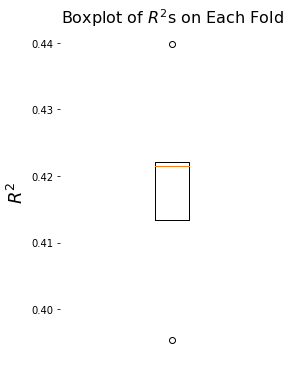

In [303]:
fig, ax = plt.subplots(1,1, figsize=(4,6))

ax.boxplot(valid_scores)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylabel('$R^2$', fontsize=18)
ax.set_title('Boxplot of $R^2$s on Each Fold', fontsize=16)
ax.set_xticklabels('')
ax.tick_params(axis='x', which='both', bottom='false')

#### 3.7 We've used cross-validation to generate error bars around our $R^2$ scores, but another use of cross-validation is as a way of model selection.  Let's construct the following model alternatives ...

In [562]:
# build design matrix for degree n polynomial regression
def get_poly_dataset2(df, n=4):
    
    # get continuous variables
    cont_predictors = df[['hour', 'temp', 'hum']].copy()

    # convert to numpy array
    design_mat = df.as_matrix()
    
    # degree 4 polynomials
    transformer_n = PolynomialFeatures(n, include_bias=False)

    # for each continuous predictor
    for predictor in cont_predictors:   
        
        # append new polynomial predictors to the design matrix
        new_predictors = transformer_n.fit_transform(
            cont_predictors[predictor].values.reshape(-1, 1))[:,1:]
        design_mat = np.concatenate([design_mat, new_predictors], axis=1)

    # add the names of new predictors to list of columns   
    new_cols = []
    for i in range(len(cont_predictors.columns)):
        for j in range(n-1):
            #new_cols.append(cont_predictors[i] + str(j+2))
            new_cols = new_cols + [cont_predictors.columns[i] + str(j+2)]
            
        
        #new_cols = new_cols + [cont_predictors.columns[i] + '2',
        #                       cont_predictors.columns[i] + '3',
        #                       cont_predictors.columns[i] + '4']
    cols = list(df.columns) + new_cols
    
    # recreate DataFrame with new predictors
    design_df = pd.DataFrame(data=design_mat,
                             index=range(len(design_mat)),columns=cols)    
        
    return design_df

In [563]:
# Get Design Matrices
BaseFeatures_xtrain = x_train[BikeOLS_significant_bootstrap]
BaseFeaturesPoly2_xtrain = get_poly_dataset2(BaseFeatures_xtrain, 2)
BaseFeaturesPoly4_xtrain = get_poly_dataset2(BaseFeatures_xtrain, 4)

design_mats = [BaseFeatures_xtrain, BaseFeaturesPoly2_xtrain, BaseFeaturesPoly4_xtrain]

In [564]:
n_folds = 5
kfold = KFold(n_folds, shuffle=True)

# declare array of R-Squareds of each model
train_scores = np.zeros((len(design_mats), n_folds))
valid_scores = np.zeros((len(design_mats), n_folds))

# Fold index
fold = 0
    
for train, valid in kfold.split(range(len(design_mats[0]))):    
    
    # For Each Model
    for i, design_mat in enumerate(design_mats):
        
        # build the linear regression model
        lin_reg = LinearRegression()
    
        # Fit, Make Predictions
        lin_reg.fit(design_mat.loc[train], y_train.loc[train])
        Ytrain_pred = lin_reg.predict(design_mat.loc[train])
        Ytrain_valid = lin_reg.predict(design_mat.loc[valid])
    
        # Calculaate R-Squared for the training and validation sets
        train_scores[i, fold] = r2_score(y_train.loc[train], Ytrain_pred)
        valid_scores[i, fold] = r2_score(y_train.loc[valid], Ytrain_valid)
    
    fold += 1

In [565]:
means = {'BaseFeautes': np.mean(valid_scores[0]),
         'Poly2': np.mean(valid_scores[1]),
         'Poly4': np.mean(valid_scores[2])}

stds = {'BaseFeautes': np.std(valid_scores[0]),
         'Poly2': np.std(valid_scores[1]),
         'Poly4': np.std(valid_scores[2])}

model_comparison = pd.DataFrame([means, stds]).T
model_comparison.columns = ['mean_R2', 'std_R2']
model_comparison

,mean_R2,std_R2
BaseFeautes,0.404132,0.006810
Poly2,0.498952,0.010250
Poly4,0.549086,0.009479


<HR>
The model with polynomial features to order 4 maximizes the mean $R^2$, so it is best model of the three.
<HR>

#### 3.8 Visualize the $R^2$ scores generated for each model from 5-fold cross validation in box and whiskers plots.  Do the box and whisker plots influence your view of which model was best? ...

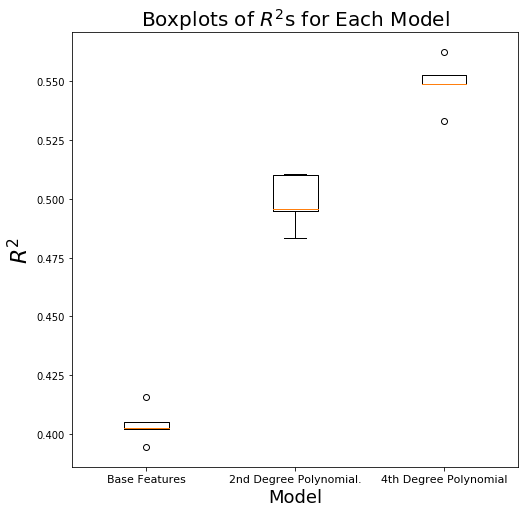

In [566]:
# Make List of Model Scores
scores = [valid_scores[0], valid_scores[1], valid_scores[2]]

fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.boxplot(scores)
ax.set_xlabel('Model', fontsize=18)
ax.set_ylabel('$R^2$', fontsize=22)
ax.set_title('Boxplots of $R^2$s for Each Model', fontsize=20)
ax.set_xticklabels(['Base Features', '2nd Degree Polynomial.', '4th Degree Polynomial'], fontsize=11)
plt.show()

<HR>
The plot reassures are belief that the model with 4th degree polynomial terms is the best of the three models.
<HR>

#### 3.9 Evaluate each of the model alternatives on the  test set.  How do the results compare with the results from cross-validation?

In [567]:
# Get Design Matrices for the Test Set
BaseFeatures_xtest = x_test[BikeOLS_significant_bootstrap]
BaseFeaturesPoly2_xtest = get_poly_dataset2(BaseFeatures_xtest, 2)
BaseFeaturesPoly4_xtest = get_poly_dataset2(BaseFeatures_xtest, 4)

test_design_mats = [BaseFeatures_xtest, BaseFeaturesPoly2_xtest, BaseFeaturesPoly4_xtest]

In [568]:
test_scores = np.zeros(len(test_design_mats))

for i, design_mat in enumerate(test_design_mats):
        
    # build the linear regression model
    lin_reg = LinearRegression()
    
    # Fit, Make Predictions
    lin_reg.fit(design_mat, y_test)
    Ytest_pred = lin_reg.predict(design_mat)
    
    # Calculaate R-Squared for the training and validation sets
    test_scores[i] = r2_score(y_test, Ytest_pred)

print('R^2 of the basic linear regression model on test data:', round(test_scores[0], 4))
print('R^2 of the 2nd degree polynomial model on test data:', round(test_scores[1], 4))
print('R^2 of the 4th degree polynomial model on test data:', round(test_scores[2], 4))



R^2 of the basic linear regression model on test data: 0.4117
R^2 of the 2nd degree polynomial model on test data: 0.5017
R^2 of the 4th degree polynomial model on test data: 0.5545


<HR>
These results show exactly what we would have expected, given the cross-validation results.
<HR>